In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from scipy.signal import find_peaks
from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

/home/astro/phrgmk/python-path/rascal/calibrator.py:36: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [4]:
import peakutils
from scipy import stats,optimize,interpolate
import pickle
import reduction_utils.wavelength_calibration as wc

In [5]:
def rascal_find_wvl_solution(spectrum, wvl_min, wvl_max):
    peaks, _ = find_peaks(spectrum, prominence=150, distance=25, threshold=None)
    print(peaks)
    print(len(peaks))
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks,
              spectrum[peaks.astype('int')],
              spectrum.max(),
              colors='C1')
    
    peaks_refined=refine_peaks(spectrum, peaks, window_width=4)
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks_refined,0,1.05*spectrum.max(),colors='C1')
    
    c = Calibrator(peaks, elements=["He","Ar"], min_wavelength=wvl_min, max_wavelength=wvl_max)
    c.set_fit_constraints(range_tolerance=500)
    best_p = c.fit(max_tries=50000, progress=True)
    c.set_fit_constraints(n_pix=len(spectrum), ransac_thresh=2)
    best_p, x_fit, y_fit=c.match_peaks_to_atlas(best_p, polydeg=7, tolerance=10)
    c.plot_fit(spectrum, best_p, plot_atlas=True, log_spectrum=False)
    fit_diff=c.polyval(best_p,x_fit)-y_fit
    rms=np.sqrt(np.sum(fit_diff**2/len(x_fit)))
    print("Stdev error:{}A".format(fit_diff.std()))
    print(c.polyval(best_p,0))
    wvl = c.polyval(best_p, np.arange(0,row_max-row_min))
    return wvl

In [6]:
parent_direc = '/storage/astro2/phrgmk/Data/EFOSC/HATS-46/reduction_11/'

# Load in stellar spectra
s1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux_cleaned.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux_cleaned.pickle','rb'))

# Load in x positions of traces, so that we can extract the arc spectra at the same locations as the stars
trace1 = pickle.load(open(parent_direc+'pickled_objects/x_positions_1.pickle','rb'))
trace2 = pickle.load(open(parent_direc+'pickled_objects/x_positions_2.pickle','rb'))


In [7]:
# load in the frame

arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/WASP-94A/EFOSC_spec_HeAr227_0003.fits')
#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/HATS-46/EFOSC.2017-08-17T11:54:57.239.fits')

#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/WASP-49/EFOSC.2021-02-18T09:22:32.372.fits')

# extract data from relevant fits extension
arc = arc_fits[0].data
nframes = len(s1)
row_min = 100
row_max = 1000
rows = np.arange(row_min,row_max)
nrows = len(s1[0])
print(arc)
arc = arc.astype(float)
print(arc.shape)

[[ 70 246 229 ...  66  89   0]
 [200 203 221 ...  73  78  66]
 [204 213 217 ...  72  63  65]
 ...
 [191 193 181 ...  80  89  74]
 [195 166 191 ...  84  73  77]
 [183 187 170 ...  68  79  91]]
(1030, 1030)


In [8]:
slice_arc_1 = []

slice_arc_2 = []


for i, r in enumerate(rows):
    row = arc[r]
    slice_arc_1.append(row[int(trace1[nframes//2][i])])
    slice_arc_2.append(row[int(trace2[nframes//2][i])])
 
slice_arc_1 = np.array(slice_arc_1)
slice_arc_2 = np.array(slice_arc_2)

<IPython.core.display.Javascript object>


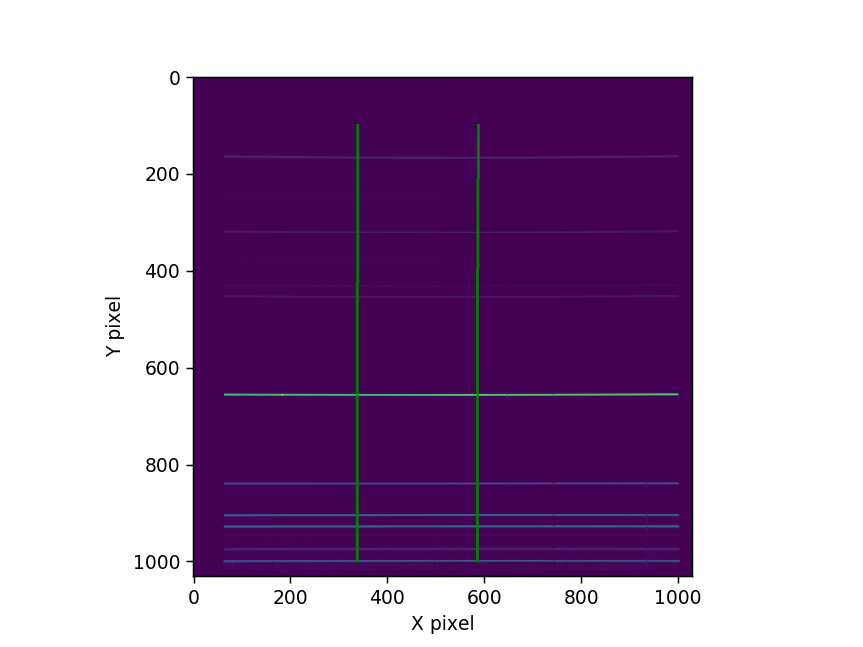

In [9]:
plt.figure()
plt.imshow(arc)
plt.plot(trace1[nframes//2],rows,color='g')
plt.plot(trace2[nframes//2],rows,color='g')
plt.ylabel('Y pixel')
plt.xlabel('X pixel')
plt.show()

<IPython.core.display.Javascript object>


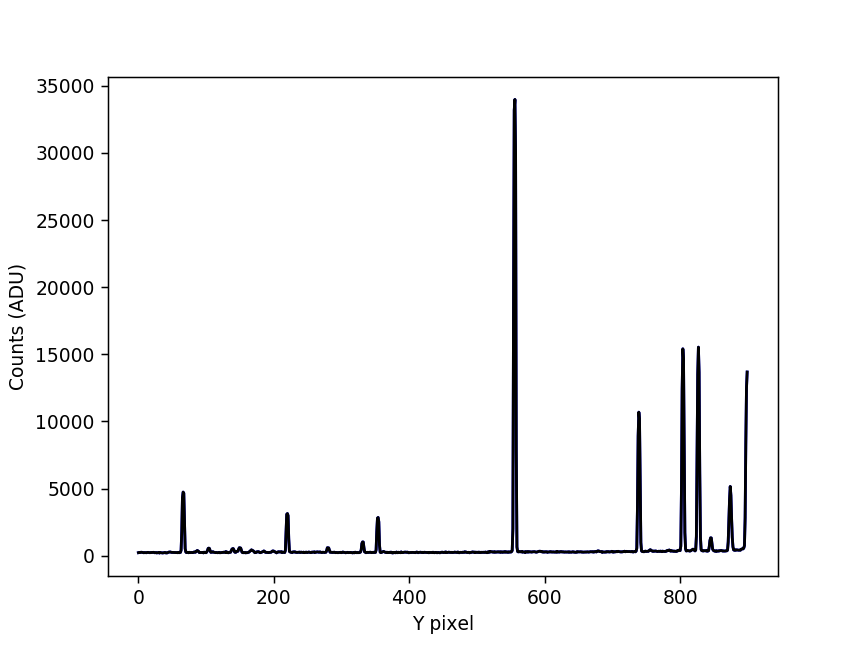

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
plt.figure()
plt.plot(slice_arc_1,color='b')
plt.plot(slice_arc_1, color='k')
plt.xlabel('Y pixel')
plt.ylabel('Counts (ADU)')
plt.show()
spectrum_1 = slice_arc_1
spectrum_2 = slice_arc_2
#spectrum_1 = np.median(arc.T, axis=0)

print(type(spectrum_2),type(spectrum_1))
#print(np.mean(abs(spectrum_1-spectrum_2)))

[ 66 104 149 220 279 354 556 739 827 874]
10


<IPython.core.display.Javascript object>


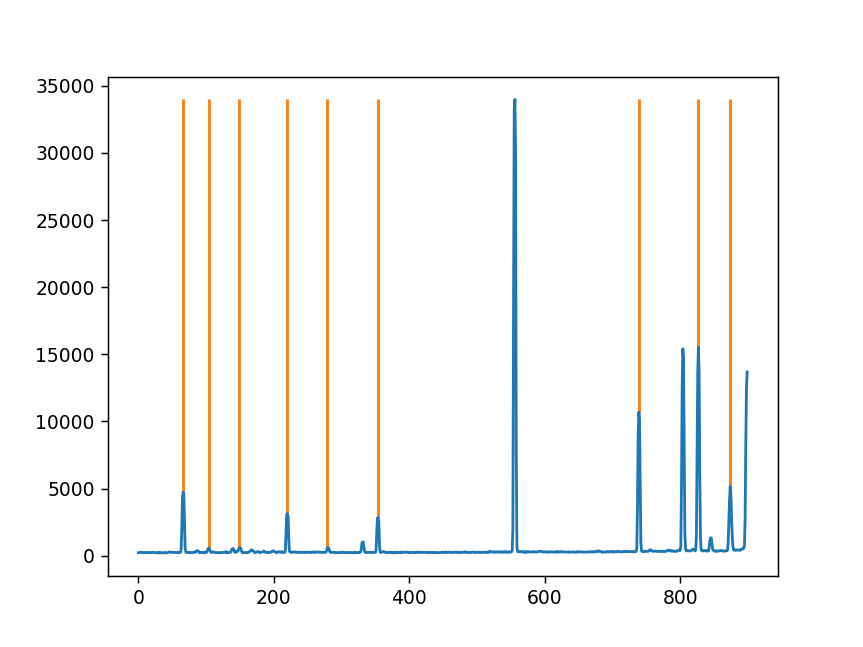

62 70
100 108
145 153
216 224
275 283
350 358
552 560
735 743
823 831
870 878


<IPython.core.display.Javascript object>


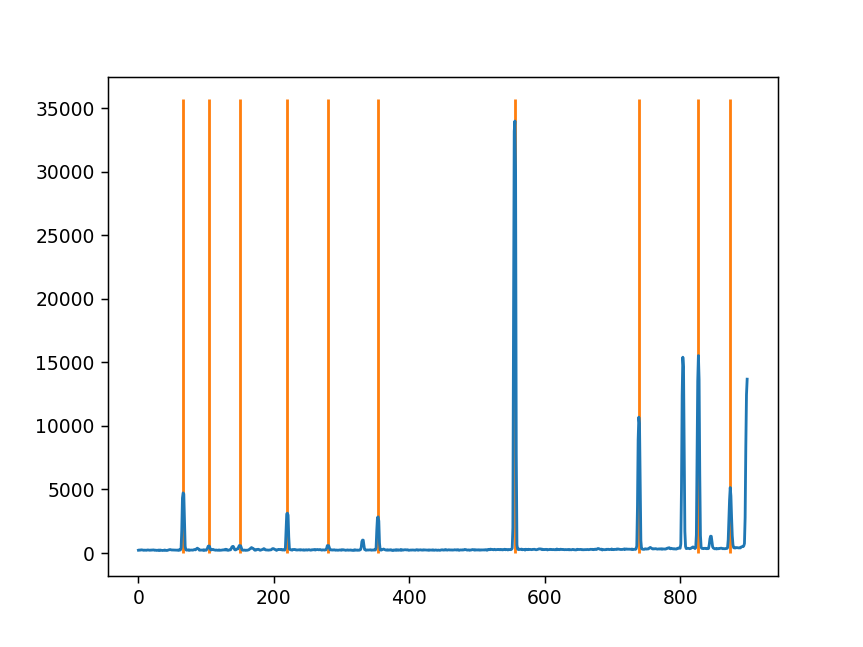

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/astro/phrgmk/python-path/rascal/calibrator.py:457: UserWarning:

Invalid fit



<IPython.core.display.Javascript object>


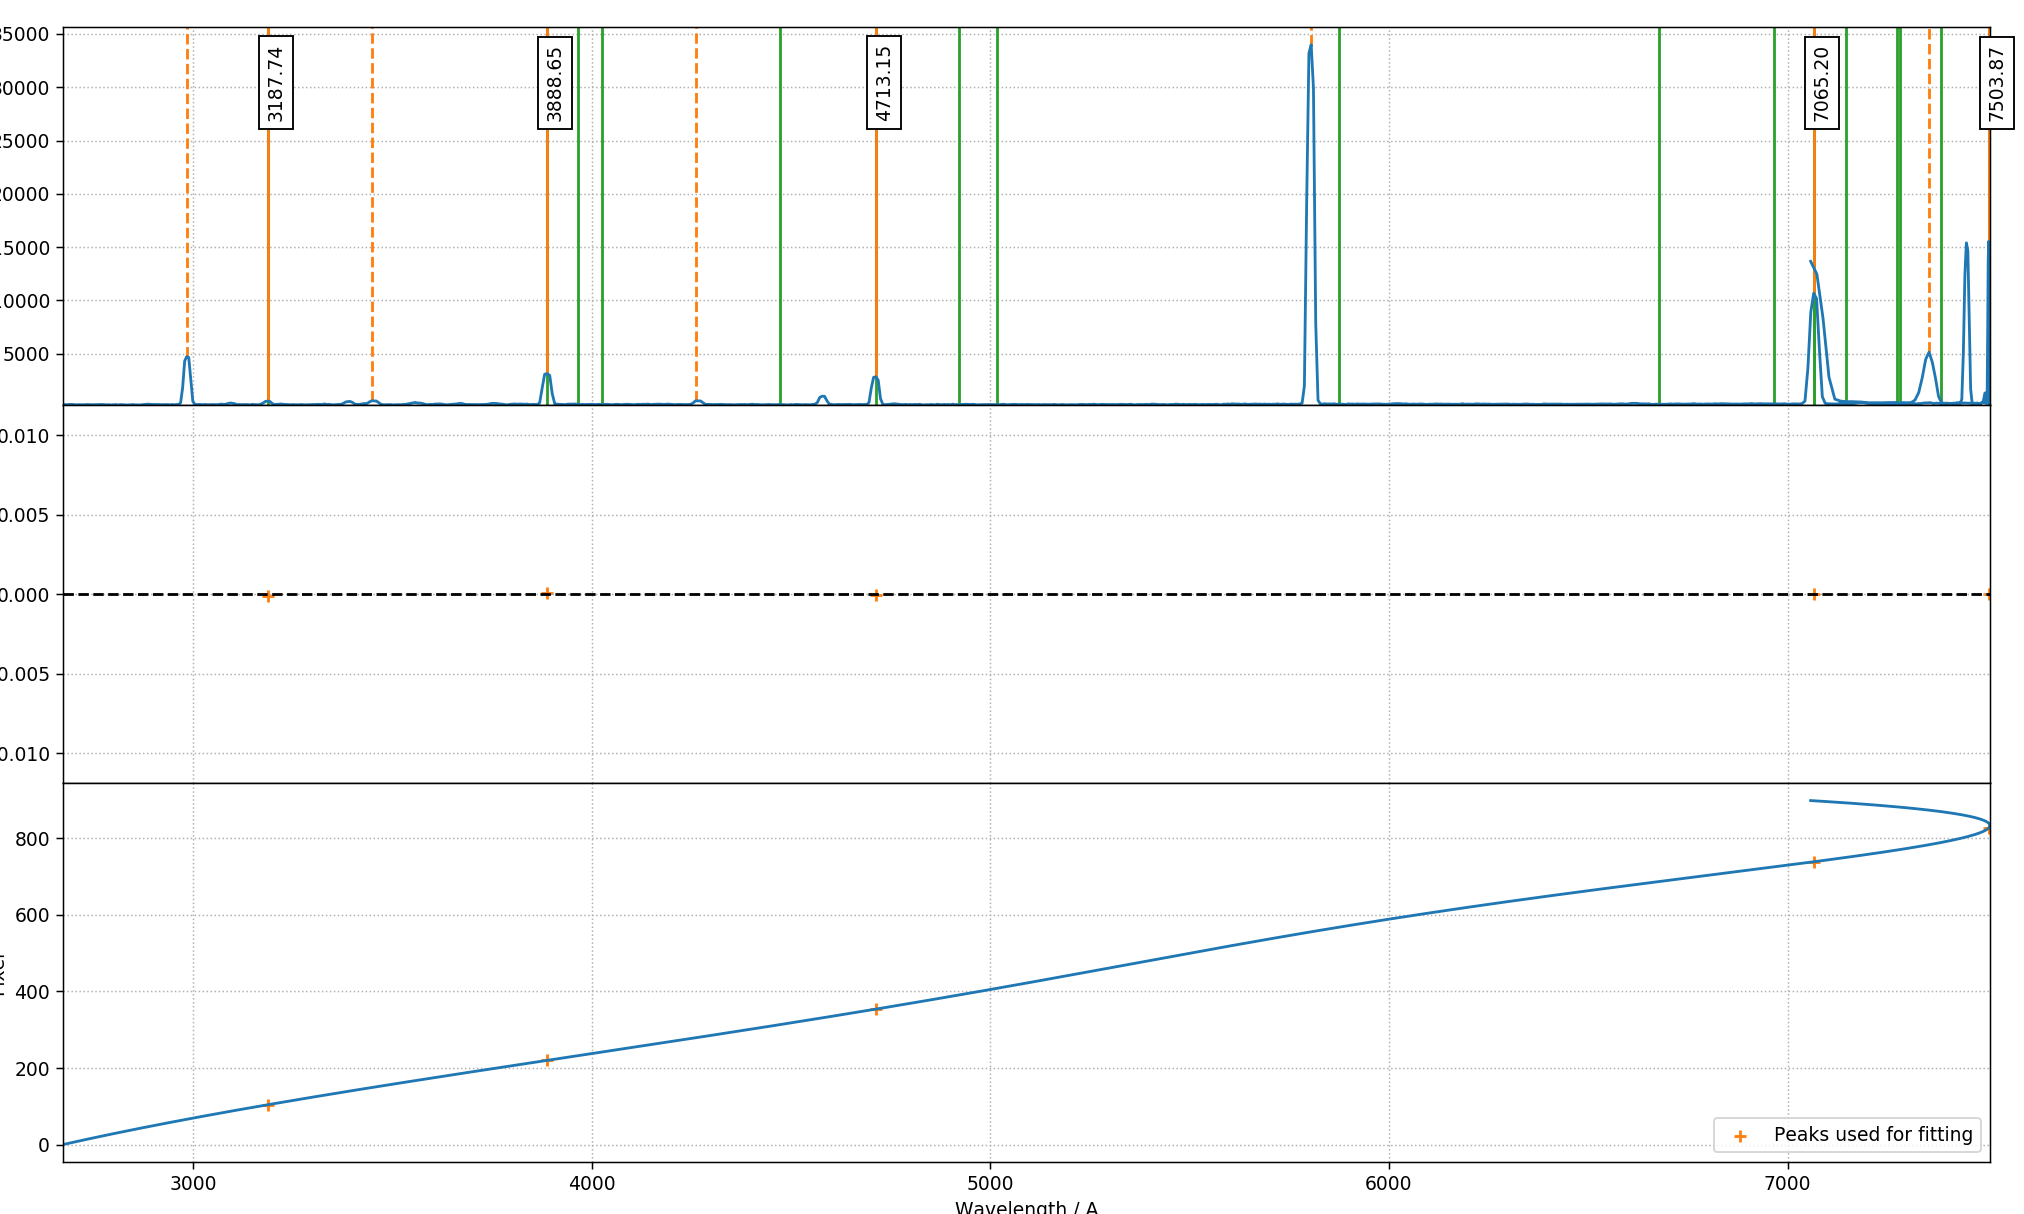

Stdev error:6.809346315080552e-05A
2674.4451220352307
[ 66 105 149 220 280 354 556 739 827 874]
10


<IPython.core.display.Javascript object>


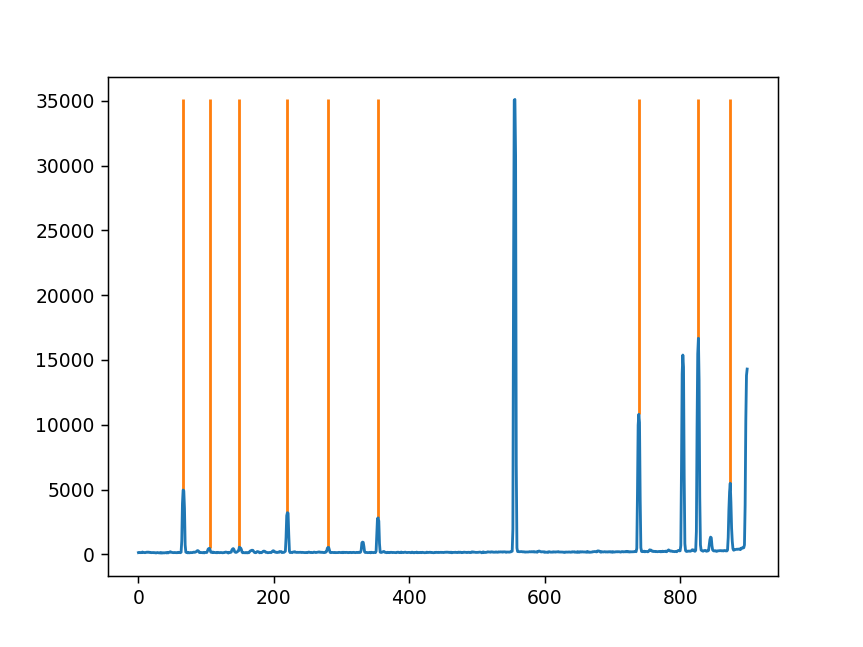

62 70
101 109
145 153
216 224
276 284
350 358
552 560
735 743
823 831
870 878


<IPython.core.display.Javascript object>


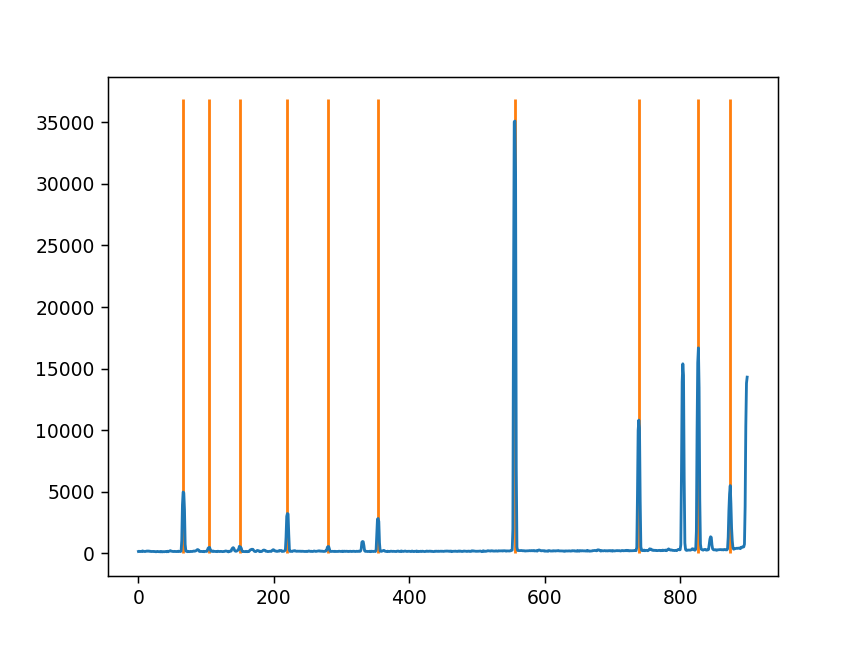

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/astro/phrgmk/python-path/rascal/calibrator.py:457: UserWarning:

Invalid fit



<IPython.core.display.Javascript object>


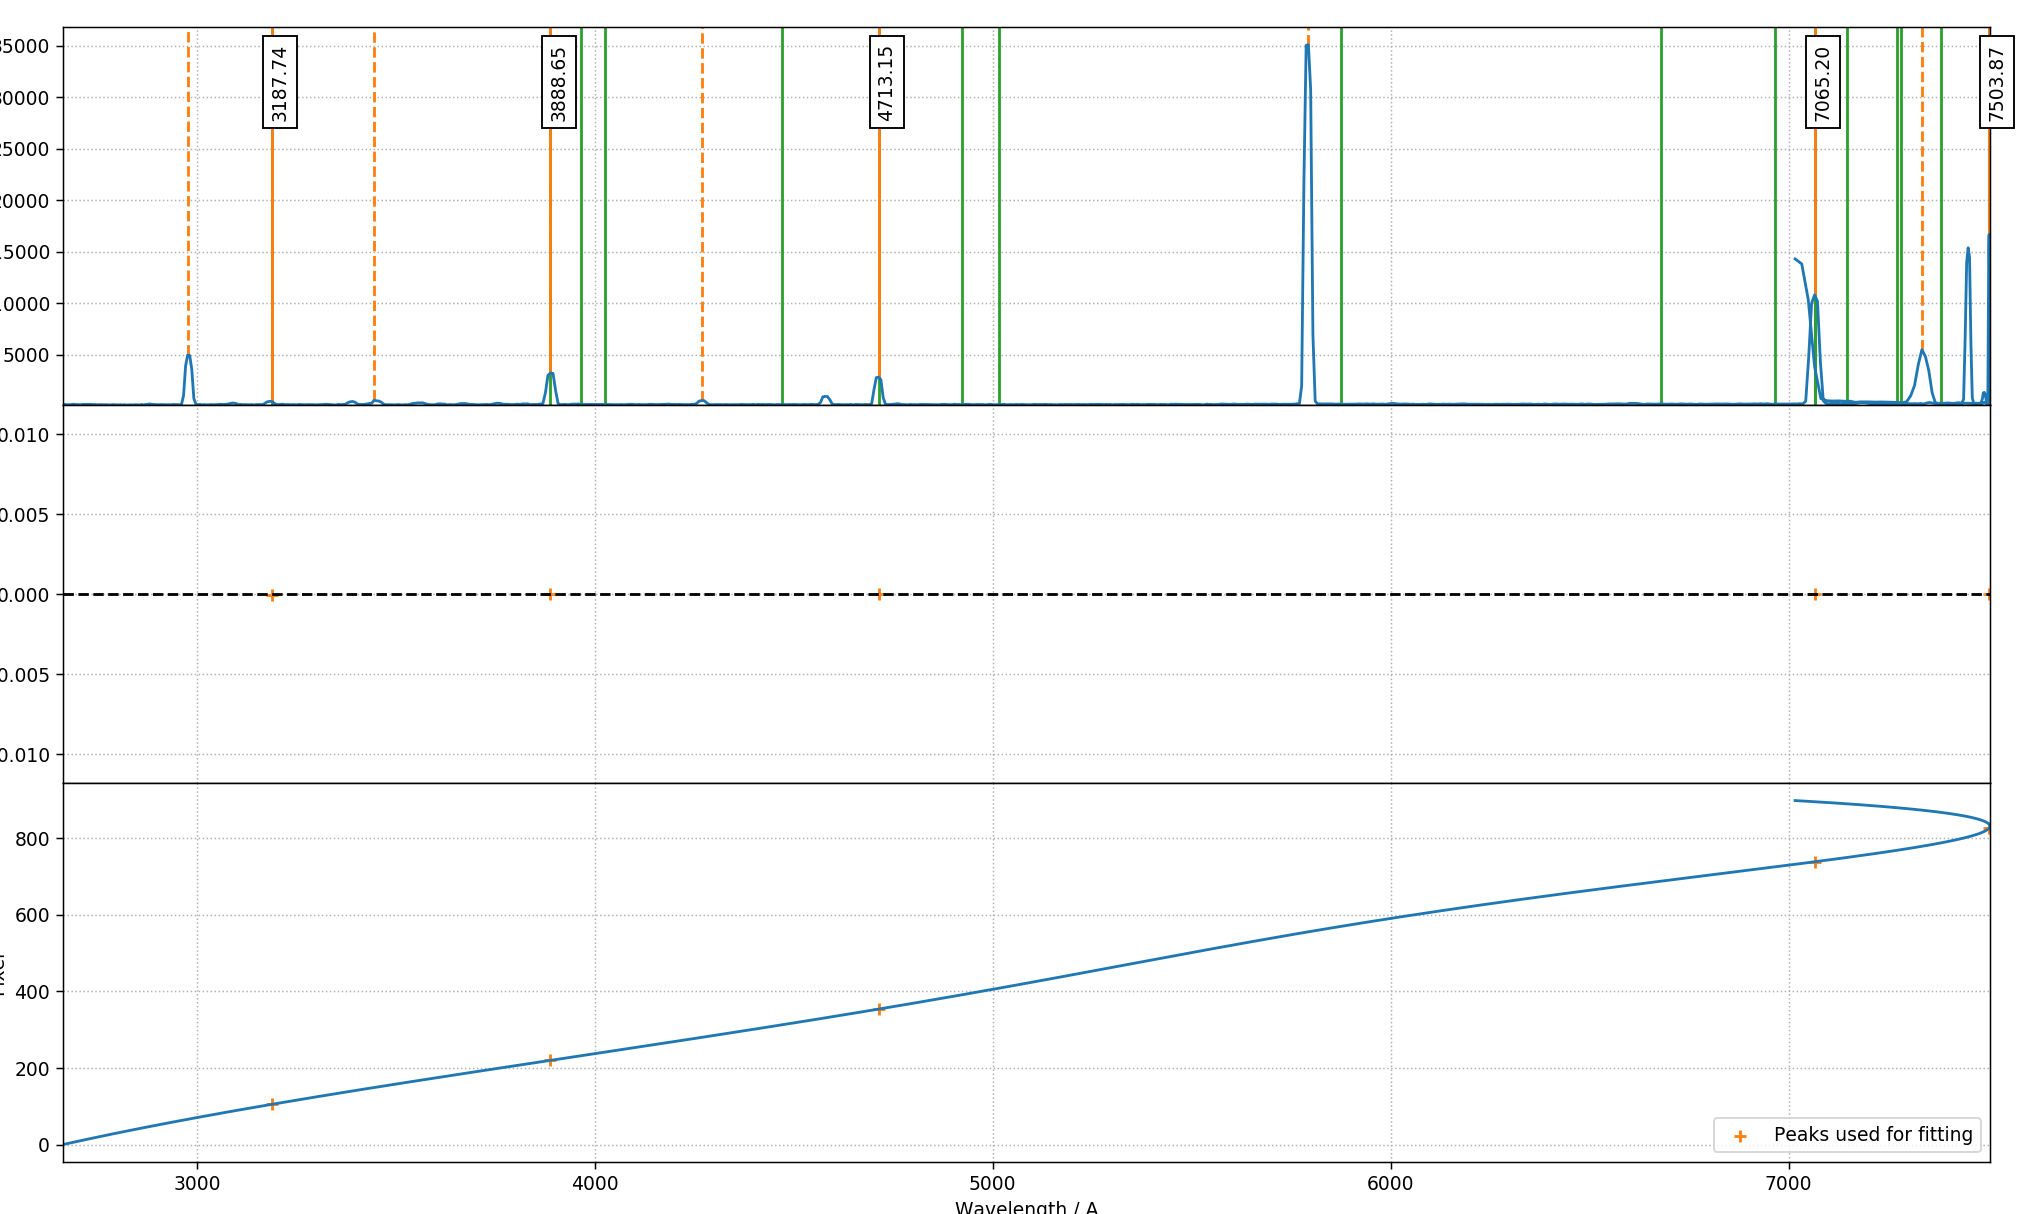

Stdev error:2.3656847835493006e-05A
2663.7591940675316


In [11]:
wvl1 = rascal_find_wvl_solution(spectrum_1, 3000, 9000)
wvl2 = rascal_find_wvl_solution(spectrum_2, 3000, 9000)

In [12]:
print(wvl2[0])
wvl1[0]

2663.7591940675316


2674.4451220352307

In [14]:
pickle.dump(wvl1,open(parent_direc+'/pickled_objects/arc_solution_trace1_rascal.pickle','wb'))
pickle.dump(wvl2,open(parent_direc+'/pickled_objects/arc_solution_trace2_rascal.pickle','wb'))